# Attention Rank Visualizer — per head or whole layer

This notebook is based on the paper [When Attention Collapses: How Degenerate Layers in LLMs Enable Smaller, Stronger Models](https://arxiv.org/html/2404.08634v3).

1. Build the attention matrix `A` for a chosen head from the `CausalSelfAttention` module.
2. Measure an **effective rank**: the smallest `k` whose top singular values explain **90%** of the matrix energy.
3. Measure **single‑column‑ness**: the fewest columns needed to cover **90%** of the squared entries of `A`.
4. Plot a heatmap of `A` and a per‑head rank profile.

**Assumptions**
- Uses `models.gpt2.attention.CausalSelfAttention`'s merged QKVO weights in `qkvo_w` of shape `(4, num_heads*head_dim, dim)`.
- Hidden states `X` of shape `(T, dim)` that enter this attention block (from the previous layer).

**Tip**: Start with short sequences (e.g., `T ≤ 128`) because SVD (Singular Value Decomposition) scales cubically with `T`.


In [1]:
import torch
import matplotlib.pyplot as plt

torch.set_printoptions(precision=4, sci_mode=True)


## Metrics: effective rank (90%) and single‑column mass (90%)
- **effective_rank90(A)**: the smallest `k` so that the top `k` singular values of `A` explain at least 90% of the squared entries.
- **columns90(A)**: the fewest columns needed so that their squared entries sum to at least 90% of the squared entries of `A`.

Both are computed per head.


### Plot helpers

In [2]:
def show_attention_heatmap(A: torch.Tensor, head: int=0, title: str=None):
    """A: (H, T, T) or (T, T)."""
    plt.figure()
    if A.dim() == 3:
        M = A[head].detach().cpu().numpy()
    else:
        M = A.detach().cpu().numpy()
    plt.imshow(M, aspect='auto')
    plt.colorbar()
    plt.xlabel('Key position j')
    plt.ylabel('Query position i')
    if title:
        plt.title(title)
    plt.show()

def plot_head_ranks(ranks, title: str='Effective rank (90%) per head'):
    plt.figure()
    xs = list(range(len(ranks)))
    plt.plot(xs, ranks, marker='o')
    plt.xlabel('Head index')
    plt.ylabel('Rank-90%')
    plt.title(title)
    plt.show()

def plot_head_masses(masses, title: str='Fewest columns for 90% mass per head'):
    plt.figure()
    xs = list(range(len(masses)))
    plt.plot(xs, masses, marker='o')
    plt.xlabel('Head index')
    plt.ylabel('#columns for 90% mass')
    plt.title(title)
    plt.show()


## Single Sample, Single Layer

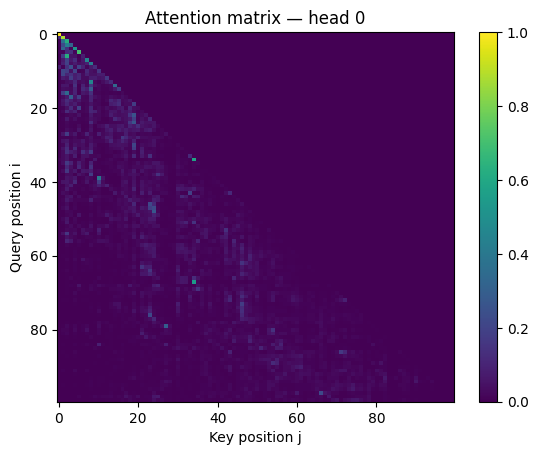

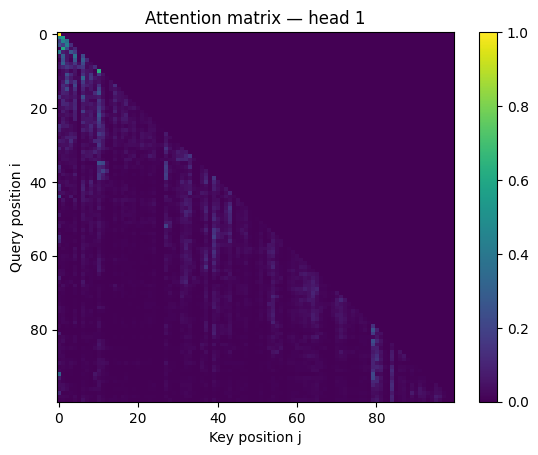

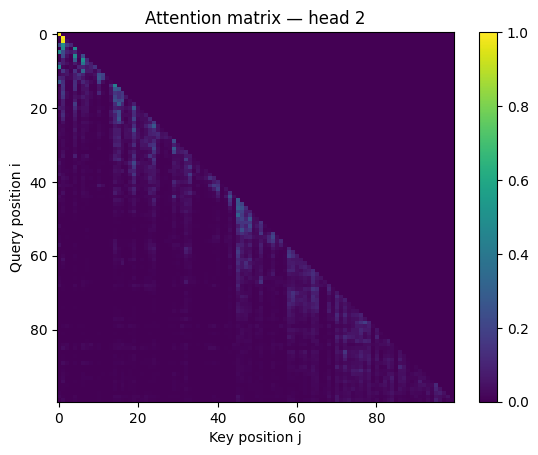

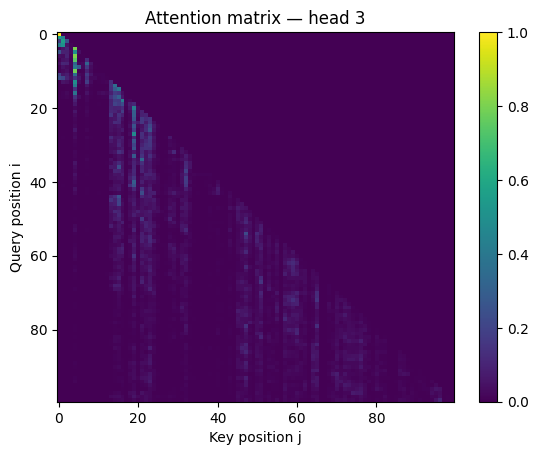

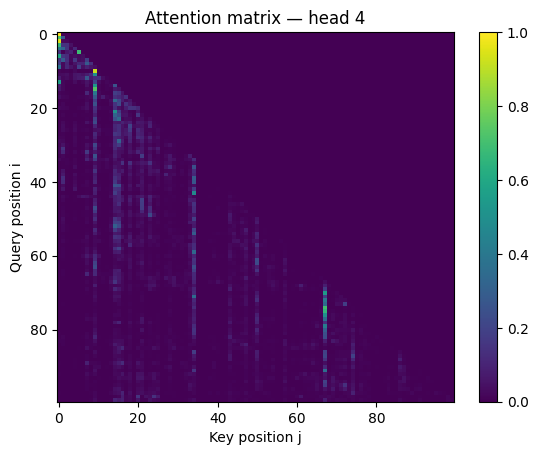

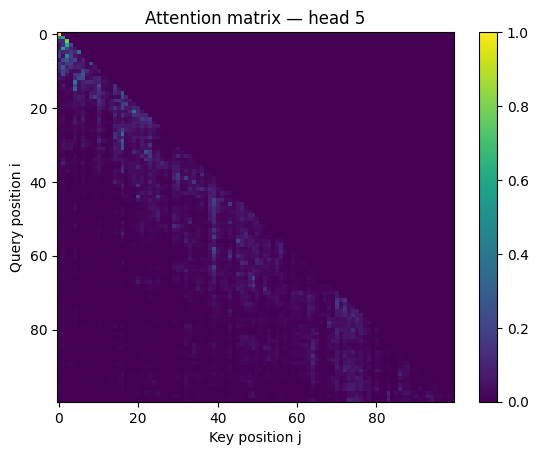

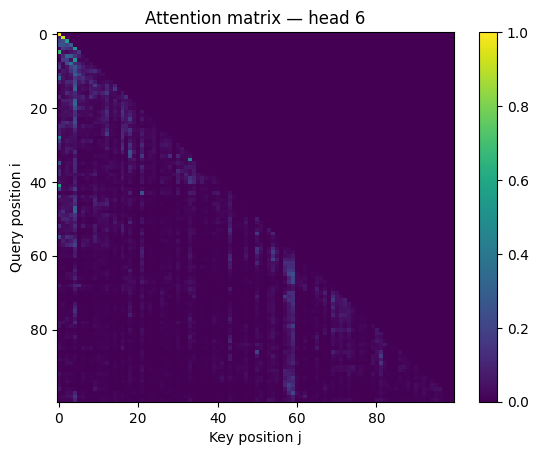

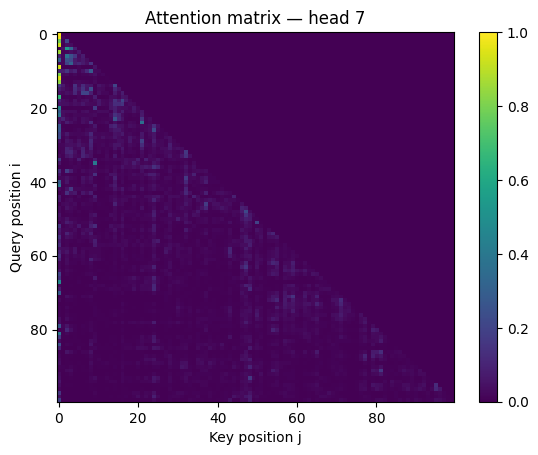

In [3]:
from models.gpt2.attention import CausalSelfAttention
from tools.metrics.attn_rank import attention_matrix_from_attn, per_head_metrics, average_per_head_over_sequences
from training.data_gen import DistributedDataGenerator
from tools.checkpoint import model_from_checkpoint

device = 'cpu'
pt = "/Users/jonathanmiddleton/models/checkpoints/350m-instruct/20251013T1953-val1.600-step000850-run1-best.pt"
model = model_from_checkpoint(pt, device=device, map_location=device).eval()

attn: CausalSelfAttention = model.blocks[0].attn

LAYER_ID = 15

def list_f(l: list) -> str:
    return "[" + ", ".join(f"{v:.2f}" for v in l) + "]"

seq_len = 100 # 100 in paper
data_loader = DistributedDataGenerator(
    "../../data/fineweb/fineweb_val_000000.bin",
    1 * seq_len,
    rank = 0,
    world_size=1,
    device=device,
)

p = next(data_loader)[0][None,:] # one sample

with torch.no_grad():
    model.prefill_batch(p, 256)
    block = model.blocks[LAYER_ID]
    X: torch.Tensor = block.in_t.squeeze(0) # (T, dim)
    A = attention_matrix_from_attn(attn, X)
    for h in range(A.shape[0]):
        show_attention_heatmap(A, head=h, title=f'Attention matrix — head {h}')


Per‑head effective ranks: [16, 10, 14, 9, 8, 15, 10, 7]
Per‑head columns@90%: [30, 23, 32, 18, 12, 39, 19, 16]
MaxRank(layer) = 16


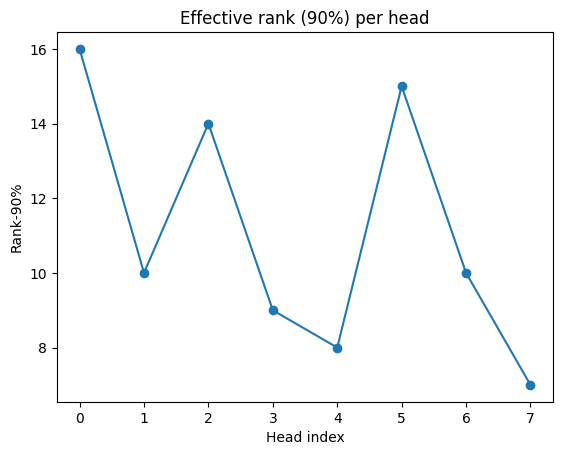

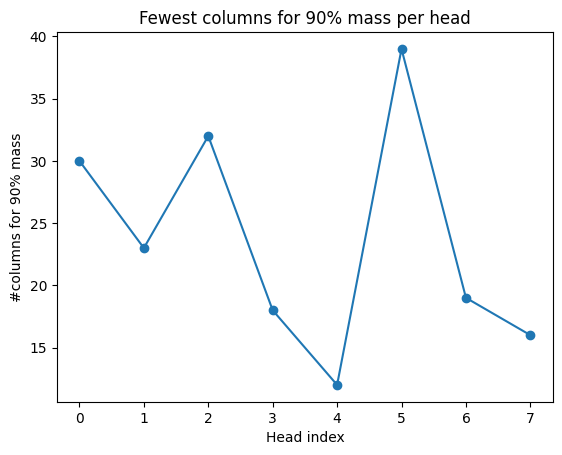

In [4]:
    ranks, masses, max_rank = per_head_metrics(A, device=device)
    print('Per‑head effective ranks:', ranks)
    print('Per‑head columns@90%:', masses)
    print('MaxRank(layer) =', max_rank)
    plot_head_ranks(ranks)
    plot_head_masses(masses)

## Batch over multiple sequences (to average per head)
- Mirroring the paper's setup: sample `N=100` sequences with `T=100`, then compute per‑head averages and finally `MaxRank(l)` as the maximum head rank per layer.
- To inspect a **single‑column** pattern directly, sort the columns of `A[h]` by their squared mass and see if the first one dominates.


In [5]:
with torch.no_grad():
    I = [inputs[None,:] for inputs, _ in (next(data_loader) for _ in range(seq_len))]
    Xs = [model.blocks[LAYER_ID].in_t[0] for inputs in I for _ in model.prefill_batch(inputs, seq_len)]

    avgs = average_per_head_over_sequences(attn, Xs, device=device)
    print("avg_ranks_per_head: ", list_f(avgs['avg_ranks_per_head']))
    print("avg_columns90_per_head: ", list_f(avgs['avg_columns90_per_head']))
    print(f"MaxRank_layer: {avgs['MaxRank_layer']:.2f}")

avg_ranks_per_head:  [13.93, 10.25, 14.18, 10.29, 9.76, 11.68, 10.16, 9.58]
avg_columns90_per_head:  [27.76, 25.00, 35.33, 22.02, 16.74, 27.95, 22.40, 22.19]
MaxRank_layer: 14.18
